# Mask R-CNN - Inspect Ballon Trained Model

* 代码和可视化以测试，调试和评估Mask R-CNN模型.

In [2]:

# Using Tensorflow-2.4.x
import tensorflow as tf
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 项目根目录
ROOT_DIR = os.path.abspath("../../")

# 导入 Mask RCNN
sys.path.append(ROOT_DIR)  # 查找库的本地版本
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon

%matplotlib inline 

# 用于保存日志和训练模型的目录
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Ballon 的训练权重
# 可以从发布界面来下载：
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_balloon.h5")  # TODO: update this path
print(BALLON_WEIGHTS_PATH)

E:\Mask_RCNN-tf2\mask_rcnn_balloon.h5


## Configurations

In [3]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "samples/balloon")
print(BALLOON_DIR)
# config.display()

E:\Mask_RCNN-tf2\samples/balloon


In [4]:
# 进行一些更改以覆盖训练配置从而进行推理.
class InferenceConfig(config.__class__):
    # 一次对一张图片进行检测
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [5]:
# 加载神经网络的设备.
# 如果在同一台机器上训练模型很有用，这时最好使用CPU 并让GPU 进行训练.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# 在训练或推理模式下检查模型：'inference' or 'training'
# TODO: “training”部分的代码还没有
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """返回Matplotlib Axes数组，以用于笔记本中的所有可视化。
        提供一个中心点来控制图形大小.
    
    调整大小属性以控制渲染图像的大小
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [7]:
# 加载 validation dataset
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# 在使用数据集前必须调用
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 13
Classes: ['BG', 'balloon']


## Load Model

In [8]:
# 在 inference 模式下创建模型
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Use fn_output_signature instead


In [9]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
# print(weights_path)
# weights_path = model.find_last()
# weights_path = "logs/mask_rcnn_balloon.h5"


# Load weights
# print("Loading weights ", weights_path)

# 为已创建的推理模型加载之前选择的权重
model.load_weights(BALLON_WEIGHTS_PATH, by_name=True)

## Run Detection

image ID: balloon.410488422_5f8991f26e_b.jpg (12) E:\Mask_RCNN-tf2\samples/balloon\val\410488422_5f8991f26e_b.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


D:\Anaconda_py3.7\Setup\envs\RTXTensor\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:  129.00000  max:  914.00000  int32
gt_mask                  shape: (56, 56, 3)           min:    0.00000  max:    1.00000  bool


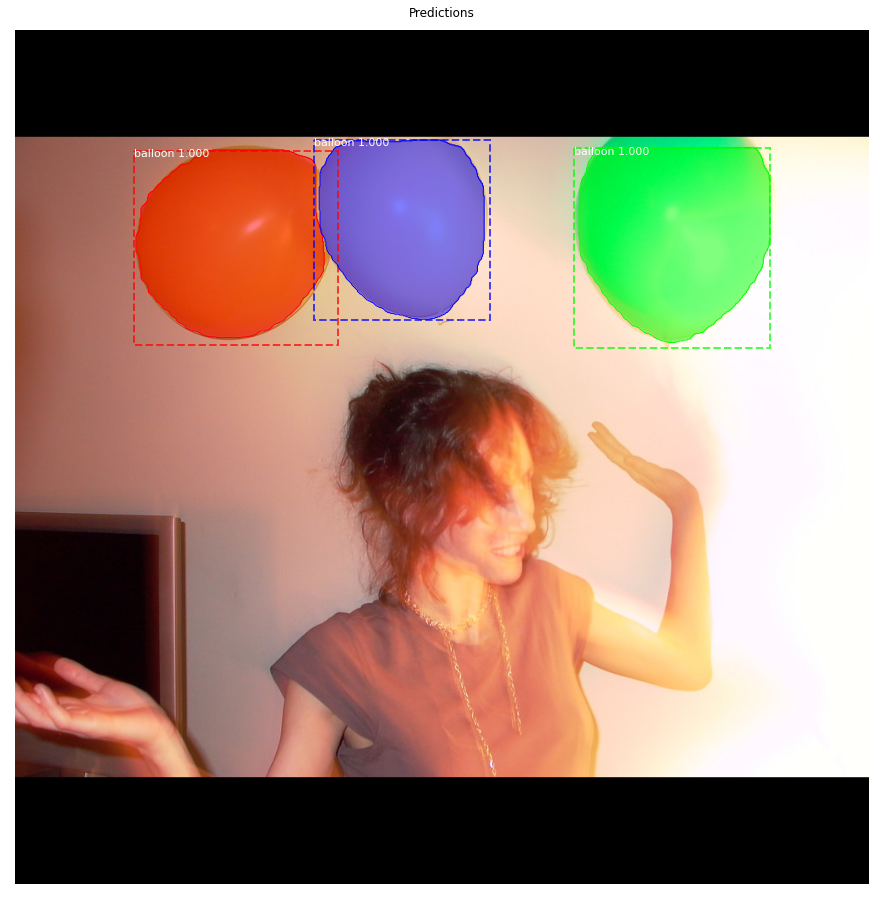

In [10]:
# 随机加载image 和 mask.
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# 运行目标检测
results = model.detect([image], verbose=1)

# 显示结果
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Color Splash

* 说明。您可以使用`splash`选项调用`Balloon.py` 无需黑色填充以获得更好的图像。

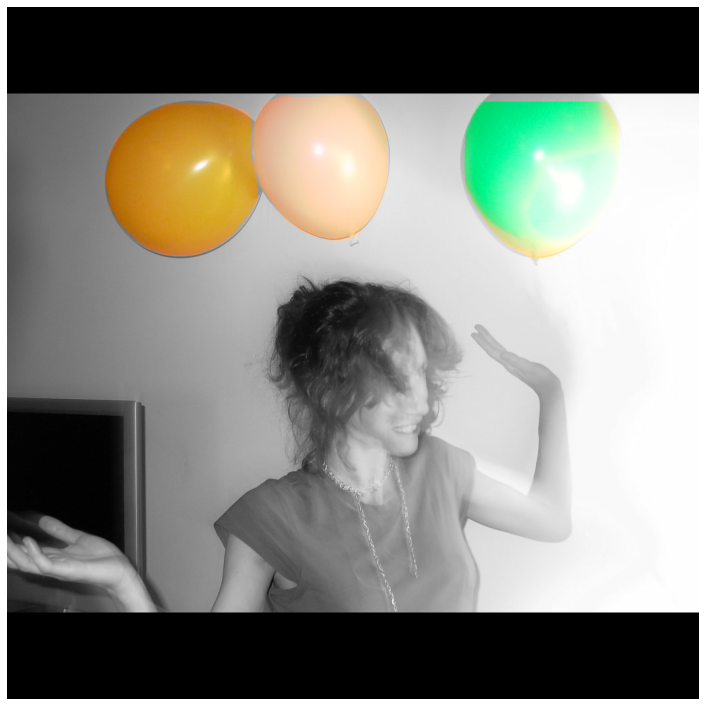

In [12]:
splash = balloon.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Step by Step Prediction

## Stage 1: Region Proposal Network

* 区域建议网络(RPN) 在图像上的许多 boxes (anchors) 上运行轻量级二进制分类器，并返回对象/无对象的得分 score. *客观性* 得分高的anchors (positive anchors) 将会传到第二阶段进行分类.



* 通常, 即使 positive anchors 也无法完全覆盖物体. 因此 RPN 还要应用到锚点的细化度(位置和大小的增量)进行回归，以对其进行移动并将其大小调整到对象的正确边界.

### 1.a RPN Targets

* RPN的目标是RPN的训练值. 为了生成目标，我们从覆盖不同尺度的整个图像的锚点网格开始，然后计算具有ground truth对象的锚点的IoU


* Positive anchors ：与 ground truth 有 IoU >= 0.7 的锚.
* negative anchors ：不覆盖任何物体的 IoU > 0.3 的锚.
* neutral anchors  : 两者之间 (i.e. 以 0.3 <= IoU < 0.7 覆盖物体) ，且不参与训练.

* * (eng) Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training



* 为了训练 RPN 回归器, 我们还计算了使锚完全覆盖 ground truth object 所需要的偏移和调整大小.

In [13]:
# 生成 RPN 训练目标
# target_rpn_match ：positive anchors --> 1
#                   negative anchors --> -1
#                   neutral anchors  --> 0
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral_anchors", neutral_anchors)

# 将细粒度 deltas 应用于 positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.54297  max:    1.25000  float64
positive_anchors         shape: (11, 4)               min:   96.00000  max:  960.00000  float64
negative_anchors         shape: (245, 4)              min: -181.01934  max: 1088.00000  float64
neutral_anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (11, 4)               min:  129.00000  max:  914.00000  float32


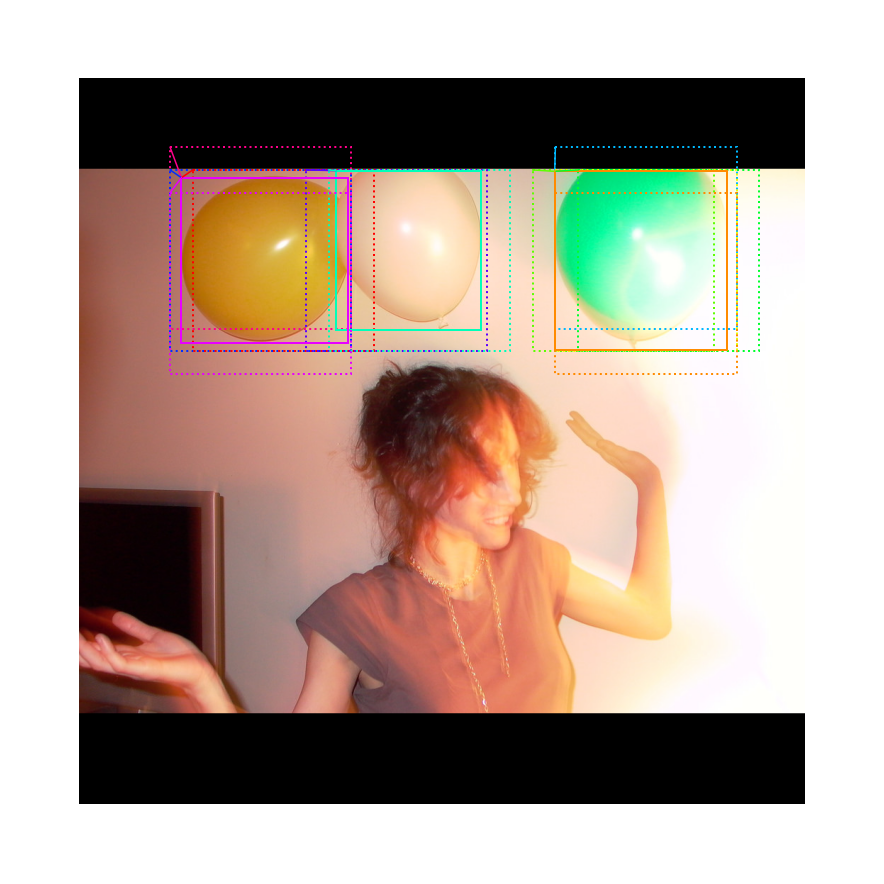

In [14]:
# 显示 positive anchors 
# refinement前是点(dotted)， refinement后是实线(solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

* 在这里我们预测 RPN graph 并显示其预测.

In [15]:
# 运行 RPN子图
# ？？？
pillar = model.keras_model.get_layer("ROI").output  # 从节点开始搜索

# TF 1.4和1.9引入了NMS的新版本。 搜索所有名称以支持TF 1.3〜1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35390  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min:  -67.29010  max:   67.70911  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (670,)                min:    0.00000  max: 5975.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


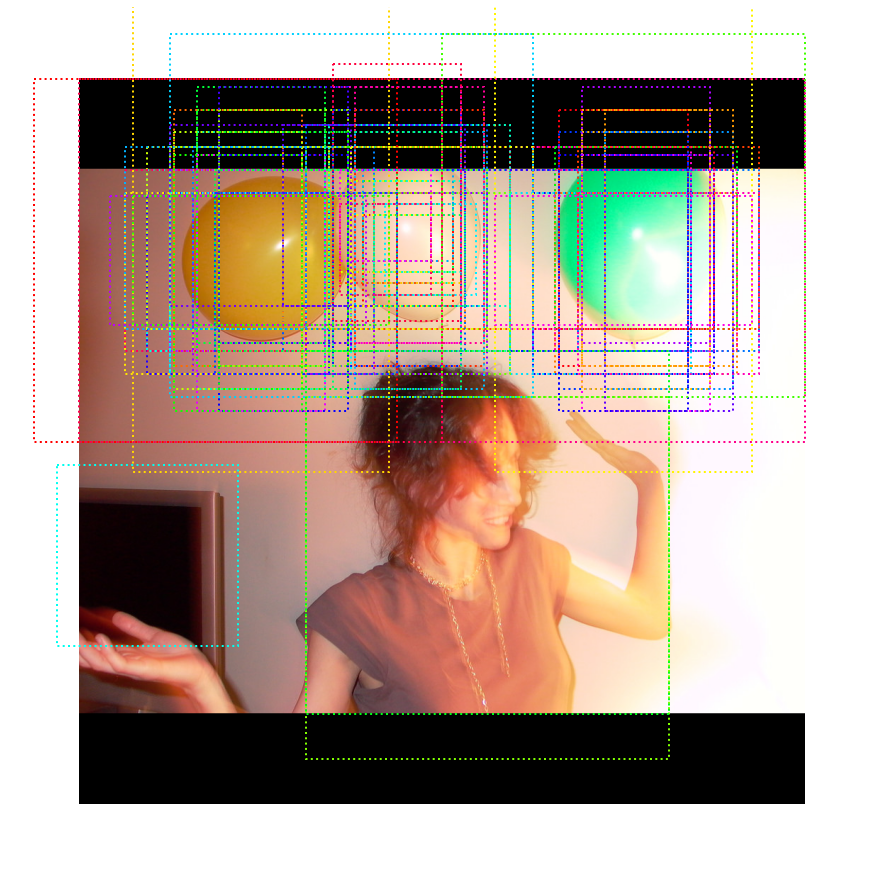

In [16]:
# 按得分显示最佳 anchors (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

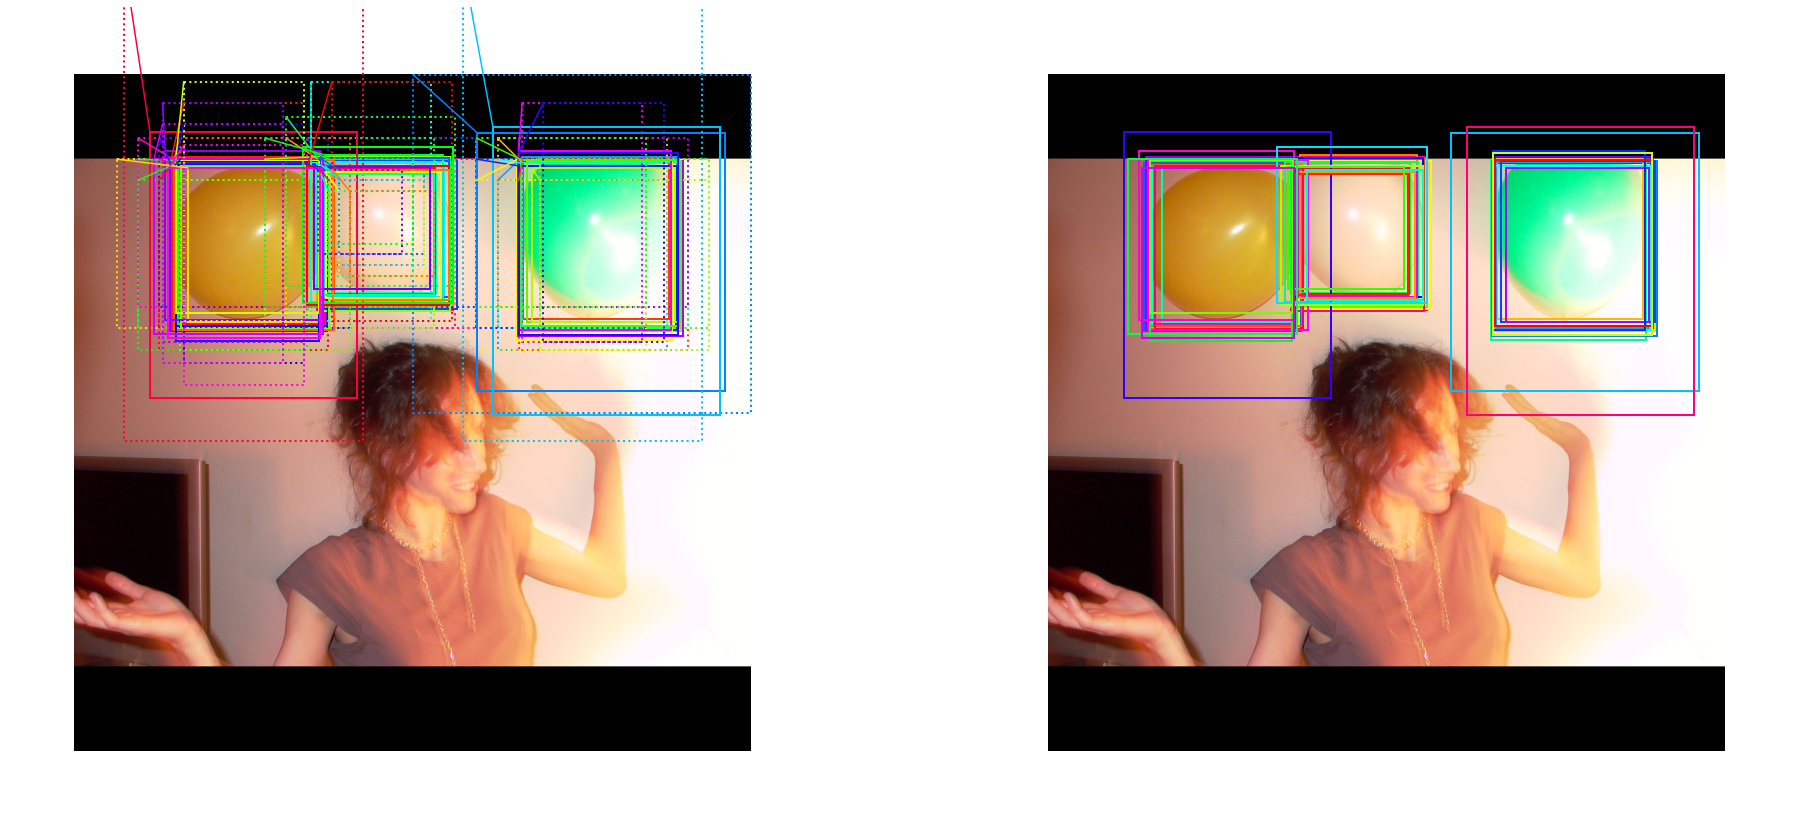

In [17]:
#显示最佳 anchors (after refinement). 然后裁剪图像边界
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

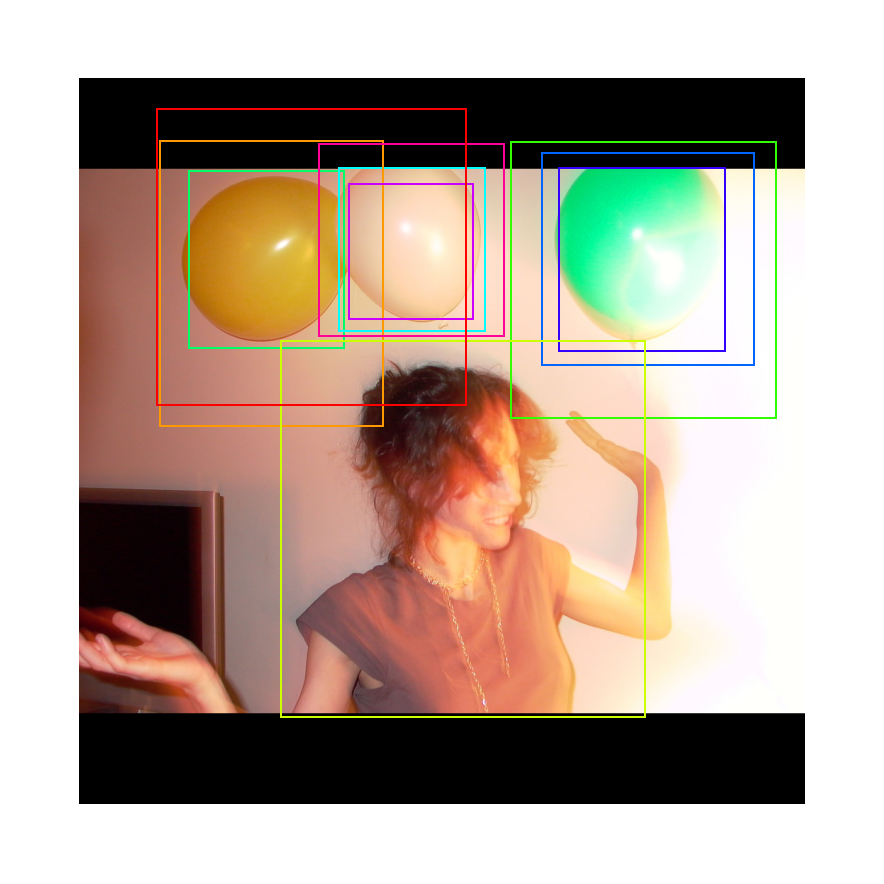

In [22]:
# 在 non-max suppression(NMS) 后显示调整后的 anchors
limit = 10
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

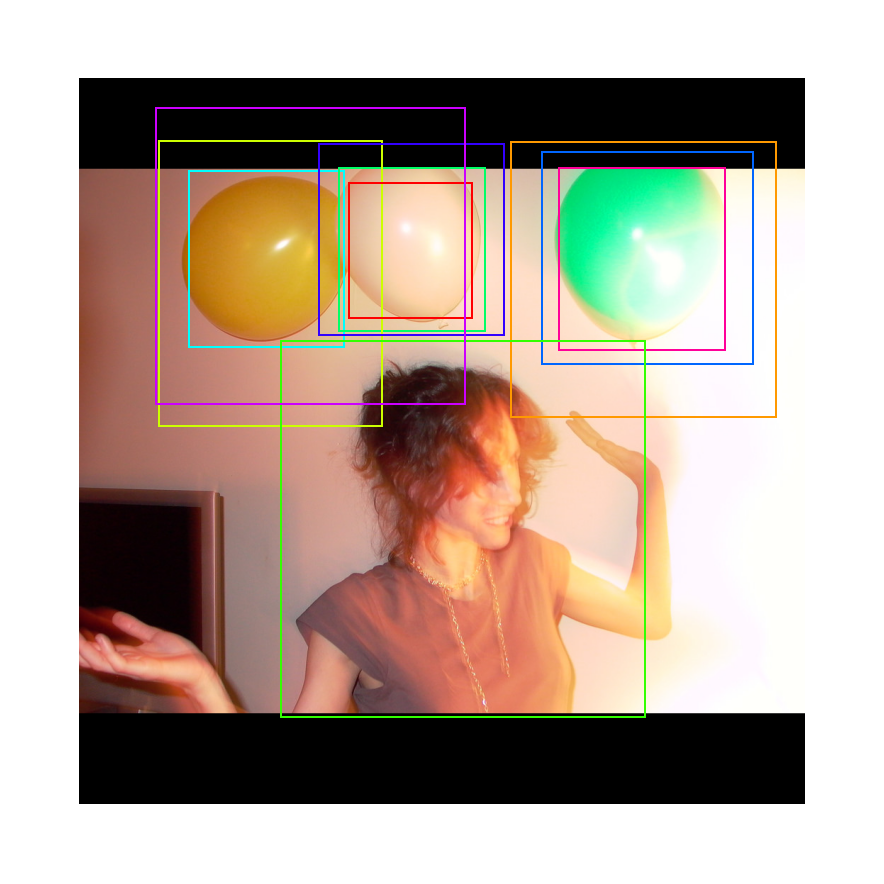

In [23]:
# 显示最终建议
# 这些与上一步相同 (NMS后的精确锚) 但坐标标准化为 [0, 1] 范围.
limit = 10
# 转换为图像坐标进行显示
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

* 此阶段从 RPN 获取区域建议并对其进行分类

### 2.a Proposal Classification

* 在建议上运行分类器头部网络 来生成符合的类别以及边界框回归

In [24]:
# 获取输入和输出到分类器头部网络 和 mask头部网络
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -4.38603  max:    5.55822  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


3 detections: ['balloon' 'balloon' 'balloon']


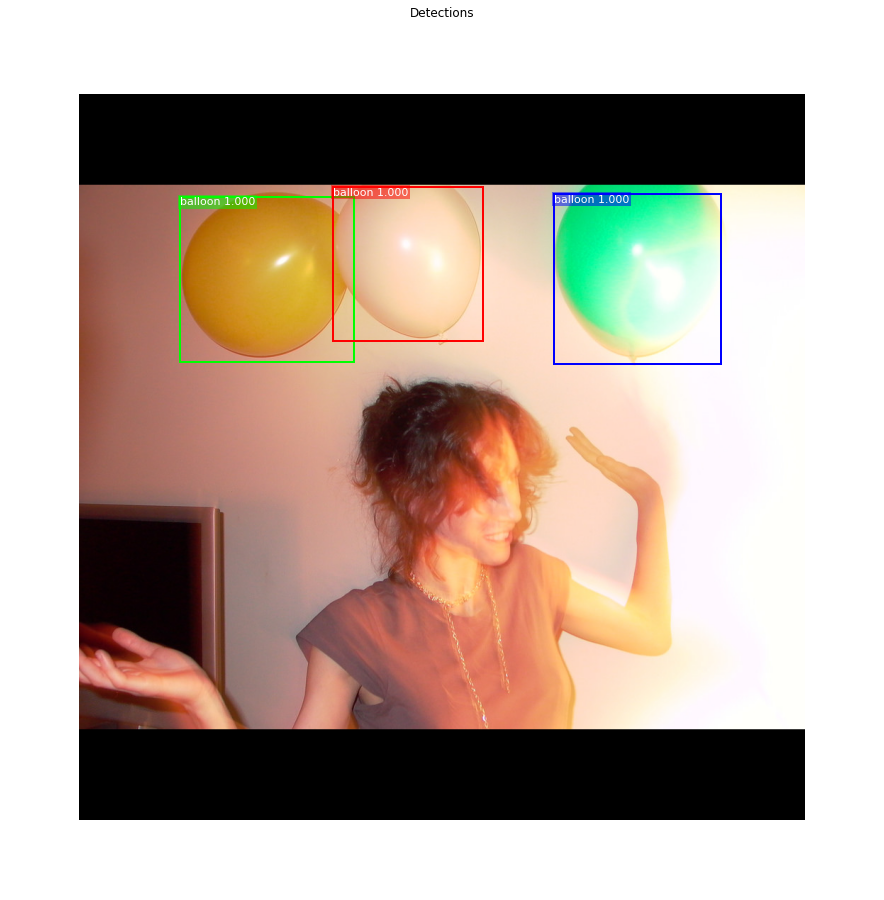

In [25]:
# Get detection class IDs. Trim zero padding.
# 获取检测到的 class IDs, 修剪0填充
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

* 这里我们深入了解处理检测的过程

In [28]:
# 建议框处于标准化坐标，缩放它们到图像坐标
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# 每个建议的 Class ID, score, and mask 
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

670 Valid proposals out of 1000
17 Positive ROIs
[('BG', 983), ('balloon', 17)]


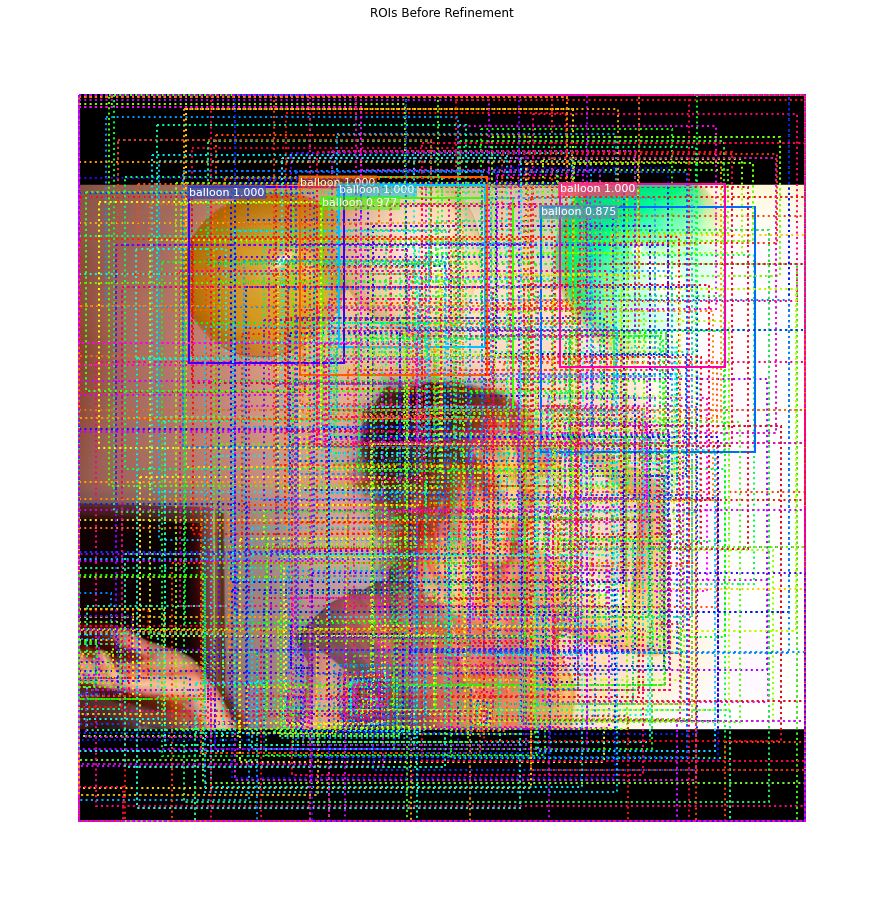

In [31]:
# 显示一个随机的建议样本
# 化为背景的建议用点框住，其余的检测到的则显示其类别和置信度得分
limit = 1000
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -4.27543  max:    5.55822  float32
refined_proposals        shape: (1000, 4)             min: -261.00000  max: 1423.00000  int32


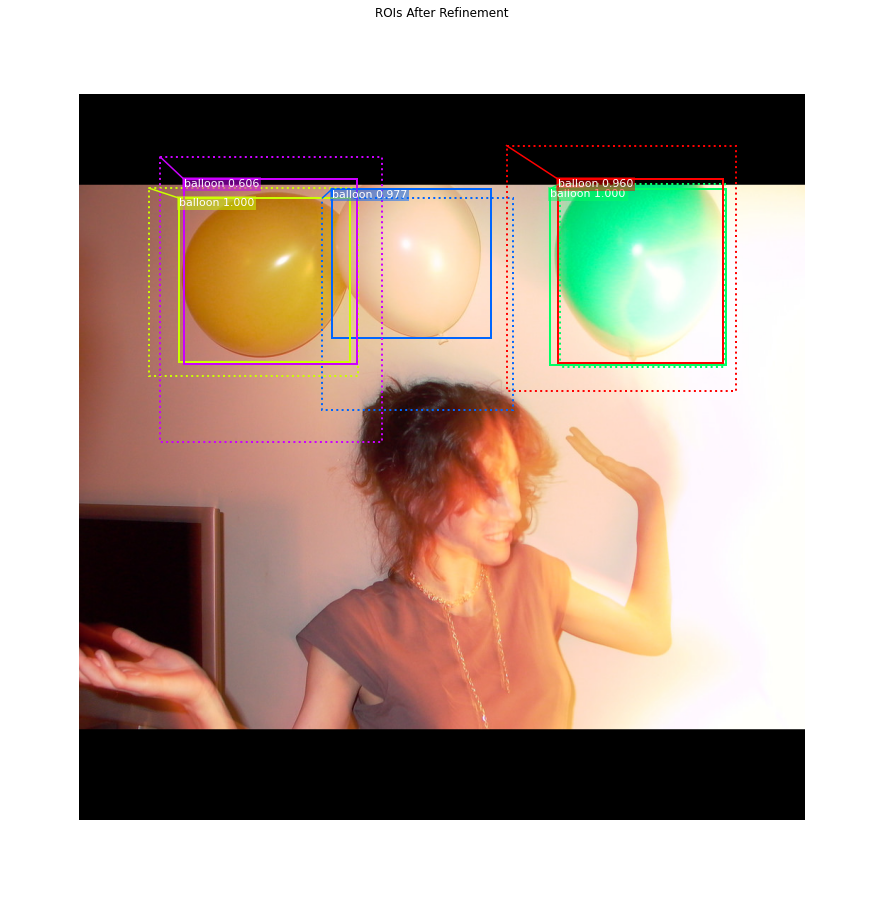

In [32]:
# 类特定的 bounding box 变化
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# 应用 bounding box 变换
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# 显示 positive proposals
# ids = np.arange(roi_boxes.shape[0])  # 显示所有
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # 显示随机样本
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [39]:
# Remove boxes classified as background
# 删除分类为背景的 boxes
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 17 detections:
[ 0  1  2  3  5  6  7 10 12 14 16 20 21 22 29 40 49]


In [40]:
# 删除低置信度的检测
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 15:
[ 0  1  2  5  6  7 10 12 14 16 20 21 22 29 49]


#### Per-Class Non-Max Suppression

In [41]:
# 对每个分类执行 non-max suppression(NMS)
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # 选择这个类的检测
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # 执行 NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

balloon               : [ 0  1  2  5  6  7 10 12 14 16 20 21 22 29 49] -> [ 0  2 22]

Kept after per-class NMS: 3
[ 0  2 22]


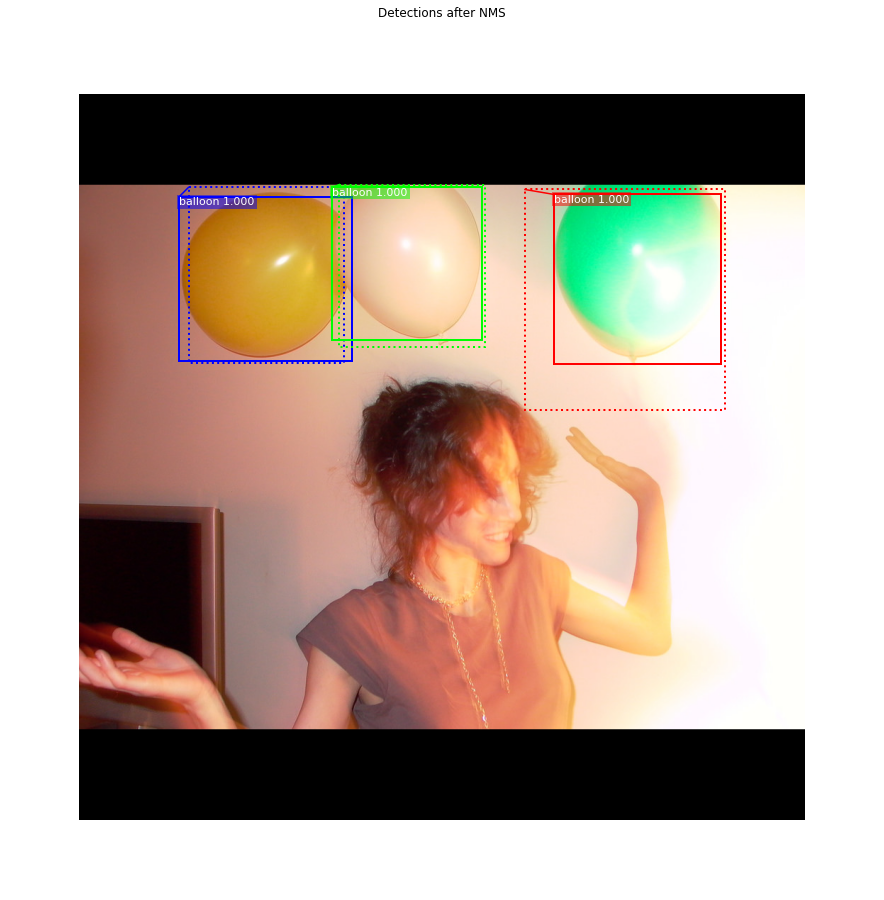

In [42]:
# 展示最终检测
ixs = np.arange(len(keep))  # 显示所有
# ixs = np.random.randint(0, len(keep), 10)  # 显示随机样本
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

* 此阶段从上一层检测(调整边界框和 class IDs)，并运行 mask 头部网络以为每个实例生成分段掩码

### 3.a Mask Targets

* 这是 mask 分支的训练目标

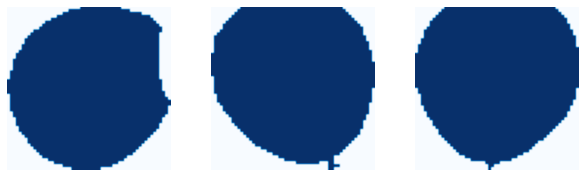

In [43]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [44]:
# 获取mask 头部网络的预测
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# 获取检测 class IDs， 修剪0填充
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
3 detections: ['balloon' 'balloon' 'balloon']


In [45]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (3, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (3, 1024, 1024)       min:    0.00000  max:    1.00000  bool


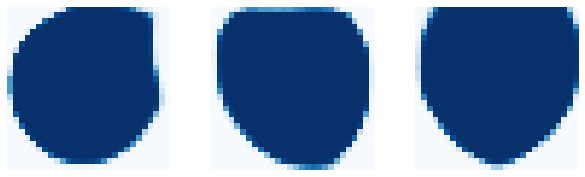

In [46]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

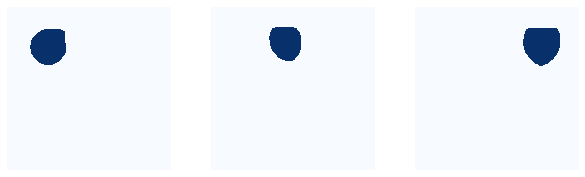

In [47]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

* 在某些情况下，它有助于查看不同层的输出并可视化他们以捕捉问题和 odd patterns

In [48]:
# 获取一些样本层的激活
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   46.46310  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.80074  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   59.06762  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -8.50793  max:  119.09123  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


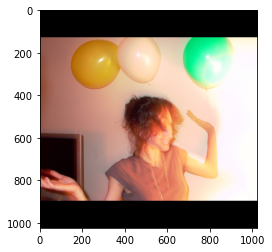

In [49]:
# 输入图像 (标准化)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

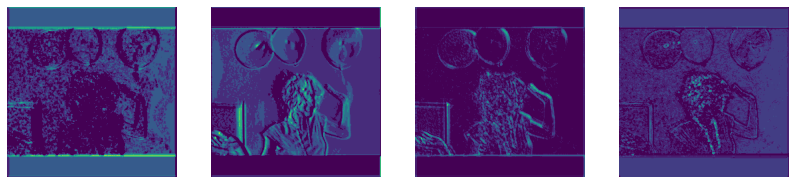

In [50]:
# 骨干网络 feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)